## Rotations in the NRSS using scipy.spatial.transform.Rotation

This notebook is intended to explain the usage of the from scipy.spatial.transform.Rotation library as it applies to NRSS Euler angle conventions. The user is encouraged to review [the Wikipedia page on Euler angles](https://en.wikipedia.org/wiki/Euler_angles), particularly the section on extrinsic vs. intrinsic.

To recap briefly, Euler angles are a widespread rotation convention for defining rotations in 3 dimensions. They are typically deined as a series of angles to be rotated about specific axes. For example, in the NRSS we use the zyz convention with rotations $\phi$ about z, $\theta$ about y, and $\psi$ about z. In the NRSS, these rotations are extrinsic, meaning they occur about the axes of a fixed coordinate system defined by the model geometry and ZYX axes. Note that we don't currently use $\phi$ because our indices of refraction are uniaxial with the extraordinary defined as starting in the z direction, and any $\phi$ rotation would not have an effect on the results.

The order of rotation is extremely important in Euler angles and different orders will produce different results. 3 Euler angles can achieve any rotation in 3D space, and it is possible to interconvert between any Euler angle convention and other conventions such as quaternions with mathematical equivalence.

This notebook will occasionally use intrinsic rotations, which are useful for the specific use case of defining possible orientations orthogonal to a specific direction. Such a need arose in defining the orientation of F4TCNQ extraordinary axis relative to P3HT extraordinary axis where they are thought to be orthogonal. Intrinsic rotations occur about the already-rotated axes rather than a fixed coordinate system. This library uses lower-case (zyz) for extrinsic rotations, and upper-case (ZYZ) for intrinsic rotations.

In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# a helper function for plotting 3D rotations
def plot_rotated_axes(ax, r, name=None, notes=None, offset=0, scale=1):
    colors = ("xkcd:greenblue", "xkcd:bright green", "xkcd:sky blue")
    offset_a = [3 * offset, 0, 0]
    loc = np.array([offset_a, offset_a])
    for i, (axis, c) in enumerate(zip((ax.xaxis, ax.yaxis, ax.zaxis), colors)):
        axlabel = axis.axis_name
        axis.set_label_text(axlabel)
        axis.label.set_color(c)
        axis.line.set_color(c)
        axis.set_tick_params(colors=c)
        line = np.zeros((2, 3))
        line[1, i] = scale
        line_rot = r.apply(line)
        line_plot = line_rot + loc
        ax.plot(line_plot[:, 0], line_plot[:, 1], line_plot[:, 2], c)
        text_loc = line[1] * 1.2
        text_loc_rot = r.apply(text_loc)
        text_plot = text_loc_rot + loc[0]
        ax.text(*text_plot, axlabel.upper(), color=c, va="center", ha="center")
    if name is not None:
        ax.text(
            offset * 3,
            1.25,
            0.75,
            name,
            color="w",
            va="bottom",
            ha="center",
            zdir=[1, 0, 0],
        )
    if notes is not None:
        ax.text(
            offset * 3,
            -1.25,
            -1.25,
            notes,
            color="w",
            va="top",
            ha="center",
            zdir=[1, 0, 0],
        )

    ax.set(xlim=(-1.25, 3 * offset + 1.25), ylim=(-1.25, 1.25), zlim=(-1.25, 1.25))


def plot_rotated_axes_series(ax, r_list, name_list=None, notes_list=None):
    ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    for i, r in enumerate(r_list):
        if notes_list is not None:
            plot_rotated_axes(
                ax, r, name=name_list[i], notes=notes_list[i], offset=i, scale=1
            )
        else:
            plot_rotated_axes(ax, r, name=name_list[i], offset=i, scale=1)
    ax.set_aspect("equal", adjustable="box")

We start at the nominal starting point for NRSS orientation. Extraordinary direction is understood to follow the Z axis here.

In [4]:
r_start

In [14]:
r_start = R.from_euler("xyz", [10, 0, 0], degrees=True)
r_start.apply([1,1,1])

array([1.        , 0.81115958, 1.15845593])

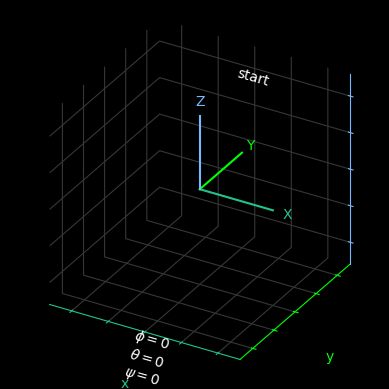

In [3]:
r_start = R.from_euler("xyz", [0, 0, 0], degrees=True)

r_list = []
r_list.append(r_start)
notes_list = []
start_note = "$\\phi = 0$\n$\\theta = 0$\n$\\psi = 0$"
notes_list.append(start_note)
name_list = []
name_list.append("start")

plt.style.use("dark_background")
plt.rcParams["grid.color"] = "xkcd:dark gray"
ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes_series(ax, r_list, name_list, notes_list)

Now we will rotate using the NRSS conventions. $\theta$ and $\psi$ here are chosen for instructional purposes but could be anything. Note that these functions are fully broadcastable, meaning that theta and psi could just as easily be large numpy arrays instead of single values. Note these Euler angle define the fibril extraordinary direction.

In [6]:
r_fibril

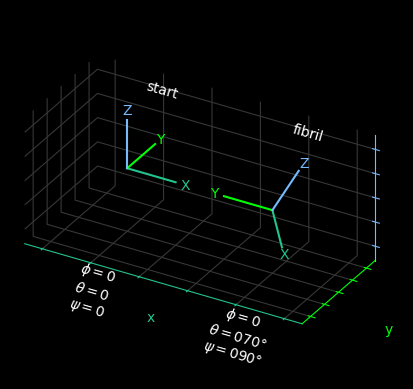

In [5]:
theta = 70
psi = 90

r_fibril = R.from_euler("zyz", [0, theta, psi], degrees=True)
r_list.append(r_fibril)
fibril_note = f"$\\phi = 0$\n$\\theta = {theta:03d}$°\n$\\psi = {psi:03d}$°"
notes_list.append(fibril_note)
name_list.append("fibril")

ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes_series(ax, r_list, name_list, notes_list)

Now we'd like to identify orientations orthogonal to the fibril extraordinary (Z). These can be found by rotation of 90° about either the intrinsic X or Y axes. Here we'll rotate about X.

In [ ]:
# note the capital X here, for intrinsic rotation
# also, when stacking rotations by *, order matters. note the order here
r_ortho = r_fibril * R.from_euler("X", 90, degrees=True)
r_list.append(r_ortho)
name_list.append("ortho")

# here I'm just extractiung the zyz euler angles that correspond to the ortho rotation
phi, theta, psi = (r_ortho.as_euler("zyz", degrees=True)).astype(int)
ortho_note = f"$\\phi = {phi:03d}$°\n$\\theta = {theta:03d}$°\n$\\psi = {psi:03d}$°"
notes_list.append(ortho_note)

ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes_series(ax, r_list, name_list, notes_list)

But there are an infinite number of orientations perpendicular to fibril, r_ortho is just one of them. The others can be accessed by intrinsic rotation about r_ortho's Y, which is now parallel to the fibril extraordinary. This defines any rotation perpendicular to fibril extraordinary and distributed rotationally about fibril extraordinary. 

In [ ]:
dist_angle = 30  # this is the rotation about the fibril extraordinary. This could be chosen from a distribution. Note this operation is also fully broadcastable

r_dist = r_ortho * R.from_euler("Y", dist_angle, degrees=True)
r_list.append(r_dist)
name_list.append("dist")

phi, theta, psi = (r_dist.as_euler("zyz", degrees=True)).astype(int)
dist_note = f"d = {dist_angle:03d}°\n$\\phi = {phi:03d}$°\n$\\theta = {theta:03d}$°\n$\\psi = {psi:03d}$°"
notes_list.append(dist_note)


ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes_series(ax, r_list, name_list, notes_list)

Note in the NRSS we use uniaxial representations, and hence "throw away" $\phi$ because X and Y are both ordinary. In this cell, we just show what happens when you do that. Note that Z remains pointing the same, which is what we want. In other words, in NRSS there is no difference between "dist" and "uni"

In [ ]:
r_uni = R.from_euler("zyz", [0, theta, psi], degrees=True)

r_list.append(r_uni)
name_list.append("uni")
uni_note = f"$\\theta = {theta:03d}$°\n$\\psi = {psi:03d}$°"
notes_list.append(uni_note)

ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes_series(ax, r_list, name_list, notes_list)

#### appendix: animating

In [ ]:
# some ponderous utility functions
def figure_to_rgb_array(fig):
    """
    Convert a matplotlib figure to an RGB numpy array.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        The figure to be converted

    Returns
    -------
    rgb_array : numpy.ndarray
        The RGB array representation of the figure
    """
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    rgb_array = data.reshape(height, width, 3)
    return rgb_array


def encode_video_loop(frames, output_file, frame_rate=3):
    import subprocess, shlex

    """
    Encode a video from a sequence of frames, with a specified number
    of loops and still frames in between each loop.

    Parameters
    ----------
    frames : list of numpy arrays
        Frames to be encoded into the video
    output_file : str
        Path to the output video file
    frame_rate : int, optional
        Frame rate of the output video. Defaults to 3.
    """
    width, height = frames[0].shape[1], frames[0].shape[0]
    cmd = f"ffmpeg -y -s {width}x{height} -pixel_format rgb24 -f rawvideo -r {frame_rate} -i pipe: -vcodec libx264 -pix_fmt yuv420p -crf 15 {output_file}"
    process = subprocess.Popen(
        shlex.split(cmd), stdin=subprocess.PIPE, stdout=subprocess.DEVNULL
    )

    for frame in frames:
        process.stdin.write(frame.tobytes())

    process.stdin.close()
    process.wait()
    process.terminate()

In [ ]:
frames = []
for fibril_theta in np.arange(30, 90 + 30, 30):
    for fibril_psi in np.arange(0, 360, 30):
        r_fibril = R.from_euler("zyz", [0, fibril_theta, fibril_psi], degrees=True)

        fibril_note = f"$\\phi = 0$\n$\\theta = {int(fibril_theta):03d}$°\n$\\psi = {int(fibril_psi):03d}$°"

        r_ortho = r_fibril * R.from_euler("X", 90, degrees=True)
        phi, theta, psi = (r_ortho.as_euler("zyz", degrees=True)).astype(int)
        ortho_note = (
            f"$\\phi = {phi:03d}$°\n$\\theta = {theta:03d}$°\n$\\psi = {psi:03d}$°"
        )
        ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
        plot_rotated_axes_series(ax, r_list, name_list, notes_list)

        for dist_angle in np.linspace(0, 360, 180):
            r_dist = r_ortho * R.from_euler("Y", dist_angle, degrees=True)
            phi, theta, psi = (r_dist.as_euler("zyz", degrees=True)).astype(int)
            dist_note = f"d = {int(dist_angle):03d}°\n$\\phi = {phi:03d}$°\n$\\theta = {theta:03d}$°\n$\\psi = {psi:03d}$°"
            r_uni = R.from_euler("zyz", [0, theta, psi], degrees=True)
            uni_note = f"$\\theta = {theta:03d}$°\n$\\psi = {psi:03d}$°"

            r_list = [r_start, r_fibril, r_ortho, r_dist, r_uni]
            notes_list = [start_note, fibril_note, ortho_note, dist_note, uni_note]
            name_list = ["start", "fibril", "ortho", "dist", "uni"]
            ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
            fig = ax.get_figure()
            plot_rotated_axes_series(ax, r_list, name_list, notes_list)
            frames.append(figure_to_rgb_array(fig))
encode_video_loop(frames, "Euler_anim.mp4", 30)